## EX50 Download and preprocess data

In [2]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
!unzip NewsAggregatorDataset.zip

--2023-06-05 22:44:50--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29224203 (28M) [application/x-httpd-php]
Saving to: ‘NewsAggregatorDataset.zip’

NewsAggregatorDatas 100%[===================>]  27.87M  6.35MB/s    in 4.8s    

2023-06-05 22:44:55 (5.84 MB/s) - ‘NewsAggregatorDataset.zip’ saved [29224203/29224203]

Archive:  NewsAggregatorDataset.zip
  inflating: 2pageSessions.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: newsCorpora.csv         
  inflating: __MACOSX/._newsCorpora.csv  
  inflating: readme.txt              
  inflating: __MACOSX/._readme.txt   


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# read data
data = pd.read_csv('newsCorpora.csv', header=None, sep='\t', names=['ID','TITLE','URL','PUBLISHER','CATEGORY','STORY','HOSTNAME','TIMESTAMP'])

# extract data
data = data.loc[data['PUBLISHER'].isin(['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']), ['TITLE', 'CATEGORY']]

# split data
train, valid_test = train_test_split(data, test_size=0.2, shuffle=True, random_state=0)
valid, test = train_test_split(valid_test, test_size=0.5, shuffle=True, random_state=0)

# save to txt files
train.to_csv('train.txt', sep='\t', index=False)
valid.to_csv('valid.txt', sep='\t', index=False)
test.to_csv('test.txt', sep='\t', index=False)

In [2]:
print("---Train dataset---")
print(train['CATEGORY'].value_counts())
print("---Test dataset---")
print(test['CATEGORY'].value_counts())
print("---Valid dataset---")
print(valid['CATEGORY'].value_counts())

---Train dataset---
b    4481
e    4240
t    1214
m     737
Name: CATEGORY, dtype: int64
---Test dataset---
b    571
e    511
t    173
m     79
Name: CATEGORY, dtype: int64
---Valid dataset---
b    575
e    528
t    137
m     94
Name: CATEGORY, dtype: int64


## EX51 Feature Extraction


In [3]:
# Vectorization
import re

def preprocessor(text):
    """
    sample: It returns to one sample of data.
    returns: It returns string with special characters removed.
    It returns list of words with only english characters seprated by single white space.
    """
    return ' '.join(re.findall(r'\w+', text)) ## \w captures [a-zA-Z0-9] chracters in data.

def tokenizer(text):
    """
    sample: It returns to one sample of data.
    returns: It first lowers each chracter in string and then split them by single white space.
    It then returns list of words.
    """
    return text.lower().split(' ')

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(
    preprocessor=preprocessor,
    tokenizer=tokenizer,
    ngram_range=(1,2),
    stop_words='english',
    min_df=10, max_df=1.0
)

transformed_train = vectorizer.fit_transform(train['TITLE'])
transformed_valid = vectorizer.transform(valid['TITLE'])
transformed_test = vectorizer.transform(test['TITLE'])

In [4]:
vectorizer.get_feature_names_out()

array(['1', '1 2', '1 billion', ..., 'zac efron', 'zone', 'â'],
      dtype=object)

In [5]:
# Transform to data frame

x_train = pd.DataFrame(transformed_train.toarray(), columns=vectorizer.get_feature_names_out())
x_train.to_csv('train.features.txt', sep='\t', index=False)
x_valid = pd.DataFrame(transformed_valid.toarray(), columns=vectorizer.get_feature_names_out())
x_train.to_csv('valid.features.txt', sep='\t', index=False)
x_test = pd.DataFrame(transformed_test.toarray(), columns=vectorizer.get_feature_names_out())
x_test.to_csv('test.features.txt', sep='\t', index=False)

## EX52 Train

In [6]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=200, random_state=0)
model.fit(x_train, train['CATEGORY'])

LogisticRegression(max_iter=200, random_state=0)

## EX53 Predict

In [8]:
import numpy as np

def score_model(model, X):
    return [np.max(model.predict_proba(X), axis=1), model.predict(X)]

train_pred = score_model(model, x_train)
test_pred = score_model(model, x_test)

print(train_pred)


[array([0.91459452, 0.85181306, 0.95201682, ..., 0.9969586 , 0.6239302 ,
       0.99533737]), array(['b', 'e', 'e', ..., 'b', 'b', 'e'], dtype=object)]


## EX54 Accuracy score

In [9]:
from sklearn.metrics import accuracy_score

train_accuracy = accuracy_score(train['CATEGORY'], train_pred[1])
test_accuracy = accuracy_score(test['CATEGORY'], test_pred[1])
print(f'正解率（学習データ）：{train_accuracy:.3f}')
print(f'正解率（評価データ）：{test_accuracy:.3f}')

正解率（学習データ）：0.952
正解率（評価データ）：0.882


## EX55 Confusion matrix

[[4347   69    8   57]
 [  41 4182    7   10]
 [  48   69  611    9]
 [ 112   79    5 1018]]


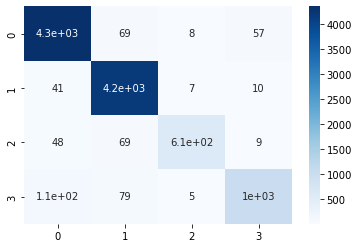

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 学習データ
train_cm = confusion_matrix(train['CATEGORY'], train_pred[1])
print(train_cm)
sns.heatmap(train_cm, annot=True, cmap='Blues')
plt.show()


[[530  24   1  16]
 [ 13 487   6   5]
 [  3  22  51   3]
 [ 35  27   2 109]]


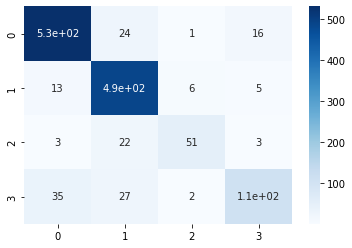

In [11]:
# 評価データ
test_cm = confusion_matrix(test['CATEGORY'], test_pred[1])
print(test_cm)
sns.heatmap(test_cm, annot=True, cmap='Blues')
plt.show()


## EX56 Precision, recall rate and F1-score

In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score

def calculate_scores(y_true, y_pred):
  # 適合率
  precision = precision_score(test['CATEGORY'], test_pred[1], average=None, labels=['b', 'e', 't', 'm'])  # Noneを指定するとクラスごとの精度をndarrayで返す
  precision = np.append(precision, precision_score(y_true, y_pred, average='micro'))  # 末尾にマイクロ平均を追加
  precision = np.append(precision, precision_score(y_true, y_pred, average='macro'))  # 末尾にマクロ平均を追加

  # 再現率
  recall = recall_score(test['CATEGORY'], test_pred[1], average=None, labels=['b', 'e', 't', 'm'])
  recall = np.append(recall, recall_score(y_true, y_pred, average='micro'))
  recall = np.append(recall, recall_score(y_true, y_pred, average='macro'))

  # F1スコア
  f1 = f1_score(test['CATEGORY'], test_pred[1], average=None, labels=['b', 'e', 't', 'm'])
  f1 = np.append(f1, f1_score(y_true, y_pred, average='micro'))
  f1 = np.append(f1, f1_score(y_true, y_pred, average='macro'))

  # 結果を結合してデータフレーム化
  scores = pd.DataFrame({'適合率': precision, '再現率': recall, 'F1スコア': f1},
                        index=['b', 'e', 't', 'm', 'マイクロ平均', 'マクロ平均'])

  return scores

print(calculate_scores(test['CATEGORY'], test_pred[1]))


             適合率       再現率     F1スコア
b       0.912220  0.928196  0.920139
e       0.869643  0.953033  0.909430
t       0.819549  0.630058  0.712418
m       0.850000  0.645570  0.733813
マイクロ平均  0.882309  0.882309  0.882309
マクロ平均   0.862853  0.789214  0.818950


## EX57 Feature weights

In [13]:
features = x_train.columns.values
index = [i for i in range(1, 11)]
for c, coef in zip(model.classes_, model.coef_):
  print(f'【カテゴリ】{c}')
  best10 = pd.DataFrame(features[np.argsort(coef)[::-1][:10]], columns=['重要度上位'], index=index).T
  worst10 = pd.DataFrame(features[np.argsort(coef)[:10]], columns=['重要度下位'], index=index).T
  display(pd.concat([best10, worst10], axis=0))
  print('\n')


【カテゴリ】b


,1,2,3,4,5,6,7,8,9,10
重要度上位,bank,ecb,argentina,yellen,piketty,fed,buy,obamacare,stocks,ipo
重要度下位,aereo,virus,victims,year old,video,heartbleed,gay,ebola,recalled,drug




【カテゴリ】e


,1,2,3,4,5,6,7,8,9,10
重要度上位,chris,movie,film,cannes,trailer,kardashian,festival,met,music,director
重要度下位,google,facebook,gm,china,risk,study,scientists,jet,microsoft,oil




【カテゴリ】m


,1,2,3,4,5,6,7,8,9,10
重要度上位,ebola,fda,cancer,study,mers,brain,cdc,drug,children,trial
重要度下位,facebook,takes,gm,twitter,apple,climate,jpmorgan,flight,bank,way




【カテゴリ】t


,1,2,3,4,5,6,7,8,9,10
重要度上位,facebook,google,microsoft,climate,apple,heartbleed,moon,comcast,nasa,tesla
重要度下位,stocks,percent,does,raise,grows,fed,valued,plane,cut,cancels


## EX58 Regulation

In [14]:
from tqdm import tqdm

result = []
for C in tqdm(np.logspace(-5, 4, 10, base=10)):
  # モデルの学習
  model = LogisticRegression(random_state=0, max_iter=10000, C=C)
  model.fit(x_train, train['CATEGORY'])

  # 予測値の取得
  train_pred = score_model(model, x_train)
  valid_pred = score_model(model, x_valid)
  test_pred = score_model(model, x_test)

  # 正解率の算出
  train_accuracy = accuracy_score(train['CATEGORY'], train_pred[1])
  valid_accuracy = accuracy_score(valid['CATEGORY'], valid_pred[1])
  test_accuracy = accuracy_score(test['CATEGORY'], test_pred[1])

  # 結果の格納
  result.append([C, train_accuracy, valid_accuracy, test_accuracy])

100%|██████████| 10/10 [01:40<00:00, 10.05s/it]


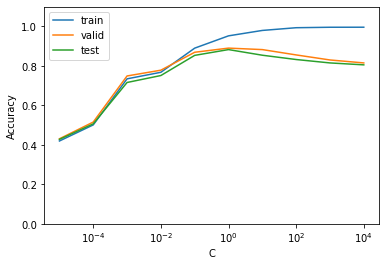

In [15]:
# 視覚化
result = np.array(result).T
plt.plot(result[0], result[1], label='train')
plt.plot(result[0], result[2], label='valid')
plt.plot(result[0], result[3], label='test')
plt.ylim(0, 1.1)
plt.ylabel('Accuracy')
plt.xscale ('log')
plt.xlabel('C')
plt.legend()
plt.show()

## EX59 Hyper-parameter tuning